<a href="https://colab.research.google.com/github/samitha278/gpt2-lite/blob/main/complete_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gdown
import tiktoken

from dataclasses import dataclass


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Data file doenload

file_id = "1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz"
url = f"https://drive.google.com/uc?id={file_id}"

output = "input.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz
To: /content/input.txt
100%|██████████| 1.12M/1.12M [00:00<00:00, 81.5MB/s]


'input.txt'

# GPT-2 Model

In [4]:
@dataclass
class GPT2Config:
    block_size : int = 1024
    vocab_size : int = 50257
    n_layer : int = 12
    n_head : int = 12
    n_embd : int = 768

In [5]:
class GPT2(nn.Module):

    def __init__(self,config):
        super().__init__()

        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.n_embd),
            wpe = nn.Embedding(config.block_size,config.n_embd),

            h = nn.ModuleList([Block(config) for i in range(config.n_layer)]),

            ln_f = nn.LayerNorm(config.n_embd),

        ))

        self.lm_head = nn.Linear(config.n_embd,config.vocab_size, bias=False)



    def forward(self,x,targets= None):

        B,T = x.shape
        assert T<= self.config.block_size   # positional embd table max size = block_size
        tx = self.transformer.wte(x)       #token embedding
        px = self.transformer.wpe(torch.arange(0,T,self.config.block_size,device=device)) #positional embedding

        x = tx+px     # add both

        for block in self.transformer.h:
          x = block(x)

        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(B*T,-1) ,targets.view(-1))
            return logits,loss



    @classmethod
    def from_pretrained(cls, model_type='gpt2'):
        from transformers import GPT2LMHeadModel
        assert model_type == 'gpt2'

        config_args = dict(n_layer=12, n_head=12, n_embd=768, vocab_size=50257, block_size=1024)
        config = GPT2Config(**config_args)
        model = GPT2(config)

        sd = model.state_dict()
        sd_keys = [k for k in sd.keys() if not k.endswith('.attn.bias')]

        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        sd_keys_hf = [k for k in sd_hf.keys() if not k.endswith(('.attn.masked_bias', '.attn.bias'))]

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(sd_keys_hf) == len(sd_keys)

        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model



# ----------------------------------------------------------------------------------

class Block(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)


    def forward(self,x):

        x = self.attn(self.ln_1(x)) + x
        x = self.mlp(self.ln_2(x)) + x

        return x



# ----------------------------------------------------------------------------------


class MLP(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config

        self.c_fc = nn.Linear(config.n_embd,4*config.n_embd)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4*config.n_embd,config.n_embd)


    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        return x

# ----------------------------------------------------------------------------------

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()

        block_size = config.block_size

        self.n_head = n_head = config.n_head
        self.n_embd = n_embd = config.n_embd


        assert n_embd % n_head == 0
        self.head_size = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3 * n_embd)     # fan out : n_head * 3 * head_size

        self.c_proj = nn.Linear(n_embd, n_embd)

        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size,device = device)))



    def forward(self, x):
        B, T, C = x.size()  # C = n_embd = n_head * head_size

        qkv = self.c_attn(x)    # B,T, 3*n_embd

        q, k, v = qkv.split(self.n_embd, dim=2)    # each : B,T, n_head * head_size

        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # B, n_head, T, head_size
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # ""
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # ""

        att = (q @ k.transpose(-2, -1)) * (self.head_size**-0.5)         # B, n_head, T, T
        att = att.masked_fill(self.bias[:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        y = att @ v        # B, n_head, T, head_size
        y = y.transpose(1, 2).contiguous().view(B, T, C)   # B, T , n_embd   (n_embd = n_head * head_size)

        y = self.c_proj(y)
        return y


## Train

In [10]:
max_iter = 50 # 10000
lr = 3e-4



#------------------------------------------------------------------

#Initialize model

config = GPT2Config()

gpt2_model = GPT2(config)
gpt2_model = gpt2_model.to(device)


#------------------------------------------------------------------


#text read
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

#get encoder
enc = tiktoken.get_encoding('gpt2')


#prepare data to train
data = text[:1000]
tokens = enc.encode(data)    #encoding


#Just one batch

B,T = 4,8
temp = torch.tensor(tokens[:B*T+1])
temp.to(device)
xb = temp[:-1].view(B,T)
yb = temp[1:].view(B,T)
xb = xb.to(device)
yb = yb.to(device)

#------------------------------------------------------------------

#Train
losses = torch.zeros((max_iter,))


optimizer = torch.optim.AdamW(gpt2_model.parameters(),lr=lr)

for i in range(max_iter):

    # xb,yb = get_batch('train')

    logits , loss = gpt2_model(xb,yb)

    #train
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



    losses[i] = loss.item()   # store losses




print(losses[-1])


tensor(0.1064)


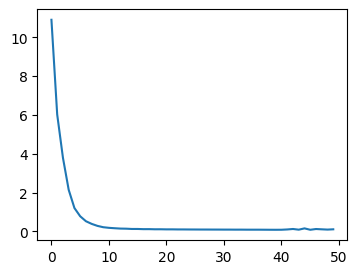

In [11]:
# plot losses just for one single batch

import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.plot(losses)
plt.show()